In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import joblib

In [2]:
from pandas.core.interchange.dataframe_protocol import Column
# Step 1: Load and preprocess the dataset
data = pd.read_csv(r'D:\Uzair\Programming\KASBIT Space Hackathon\Data\WheelTemperature.csv')
data.head()

,Date_time,wheel_temp
0,2/13/2004 13:00,24.118417
1,2/13/2004 13:10,24.118417
2,2/13/2004 13:20,24.118417
3,2/13/2004 13:30,24.118417
4,2/13/2004 13:40,24.118417


In [3]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data = data.dropna()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692998 entries, 0 to 692997
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date_time   692998 non-null  datetime64[ns]
 1   wheel_temp  692998 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.6 MB


In [5]:
data.describe()

,Date_time,wheel_temp
count,692998,692998.000000
mean,2010-09-15 18:45:00.000000768,23.868074
min,2004-02-13 13:00:00,-20.454827
25%,2007-05-31 15:52:30,22.302079
50%,2010-09-15 18:45:00,24.137805
75%,2013-12-31 21:37:30,25.583283
max,2017-04-18 00:30:00,41.483943
std,NaN,2.590357


In [6]:
# Step 2: Feature Engineering (adding more features as needed)
data['hour'] = data['Date_time'].dt.hour
data['day_of_week'] = data['Date_time'].dt.dayofweek

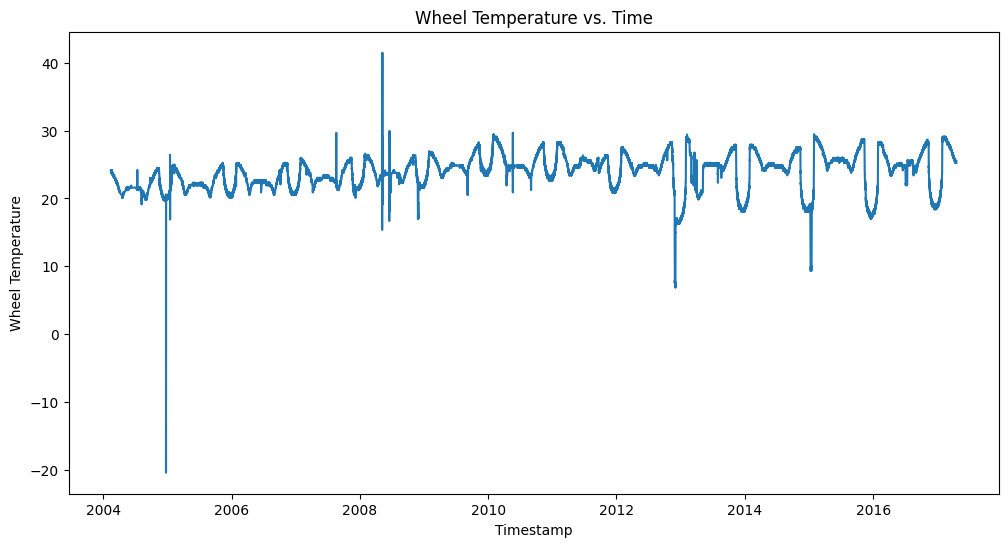

In [7]:
# Step 3: Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['Date_time'], data['wheel_temp'])
plt.xlabel('Timestamp')
plt.ylabel('Wheel Temperature')
plt.title('Wheel Temperature vs. Time')
plt.show()

In [8]:
# Step 4: Anomaly Detection with multiple models
def detect_anomalies(data):
    # Initialize arrays to store anomaly scores from different models
    anomaly_scores_if = []
    anomaly_scores_svm = []
    anomaly_scores_lof = []

    # Isolation Forest
    clf_if = IsolationForest(contamination=0.05)
    anomalies_scores_if = clf_if.fit_predict(data[['hour', 'wheel_temp', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_if = np.where(anomalies_scores_if == 1, 1, -1)

    # One-Class SVM
    clf_svm = OneClassSVM(nu=0.05)
    anomalies_scores_svm = clf_svm.fit_predict(data[['hour', 'wheel_temp', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_svm = np.where(anomalies_scores_svm == 1, 1, -1)

    # Local Outlier Factor
    clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    anomalies_scores_lof = clf_lof.fit_predict(data[['hour', 'wheel_temp', 'day_of_week']])

    # Convert boolean mask to integers (1 for normal, -1 for anomaly)
    anomalies_scores_lof = np.where(anomalies_scores_lof == 1, 1, -1)

    # Stack anomaly scores from different models
    stacked_anomalies = np.column_stack((anomalies_scores_if, anomalies_scores_svm, anomalies_scores_lof))

    # Sum the anomaly scores across models (you can customize the stacking approach)
    final_anomaly_scores = np.sum(stacked_anomalies, axis=1)

    # Define a threshold to identify anomalies
    threshold = np.percentile(final_anomaly_scores, 5)

    # Create a boolean mask for anomalies based on the threshold
    anomalies = final_anomaly_scores > threshold

    return anomalies

# Detect anomalies in the data using multiple models
data['anomaly'] = detect_anomalies(data)
data['anomaly'] = data['anomaly'].astype(int)



- If a data point is considered normal by the Isolation Forest model, it will be labeled as 1.
- If a data point is considered an anomaly by the Isolation Forest model, it will be labeled as 0

In [ ]:
data['anomaly'].value_counts()

1    98331
0    12014
Name: anomaly, dtype: int64

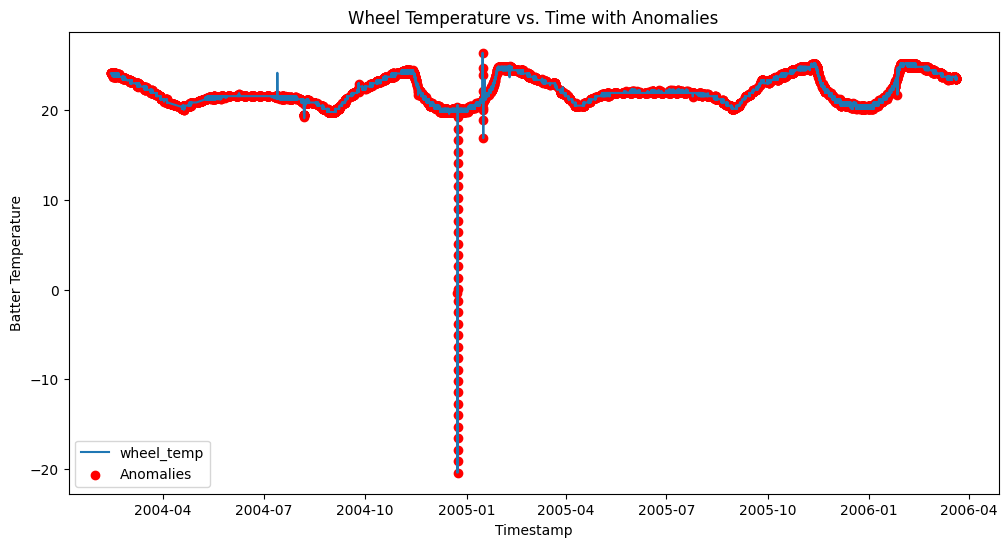

In [ ]:
# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['Date_time'], data['wheel_temp'], label='wheel_temp')
plt.scatter(data[data['anomaly'] == 0]['Date_time'], data[data['anomaly'] == 0]['wheel_temp'], c='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Batter Temperature')
plt.title('Wheel Temperature vs. Time with Anomalies')
plt.legend()
plt.show()


# Model Building
For building model we have splited the dataset in 9:1  ration 9 parts for training and testing and 1 part for validation.

In [ ]:
# Step 5: Model Building
X = data[['hour', 'day_of_week', 'wheel_temp']]
y = data['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()
svm_model = SVC()

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

SVC()

In [ ]:
# Create a VotingClassifier to combine predictions
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('svm', svm_model)
], voting='hard')

In [ ]:
# Train the VotingClassifier on the validation set
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('gb', GradientBoostingClassifier()),
                             ('svm', SVC())])

In [ ]:
# Step 6: Model Evaluation
y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9530563233494947
Confusion Matrix:
[[ 1429  1027]
 [    9 19604]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2456
           1       0.95      1.00      0.97     19613

    accuracy                           0.95     22069
   macro avg       0.97      0.79      0.85     22069
weighted avg       0.96      0.95      0.95     22069



In [ ]:
# Step 7: Predict Anomalies in Validation Data splited from the orignal dataset
# Load and preprocess new data
new_data = pd.read_csv(r"D:\Uzair\Programming\KASBIT Space Hackathon\Data\Validation Data\new_wheel_temp.csv")
new_data['Date_time'] = pd.to_datetime(new_data['Date_time'])
new_data['hour'] = new_data['Date_time'].dt.hour
new_data['day_of_week'] = new_data['Date_time'].dt.dayofweek


In [ ]:
# Use the trained model to predict anomalies in new data
new_data['anomaly'] = voting_classifier.predict(new_data[['hour', 'day_of_week', 'wheel_temp']])

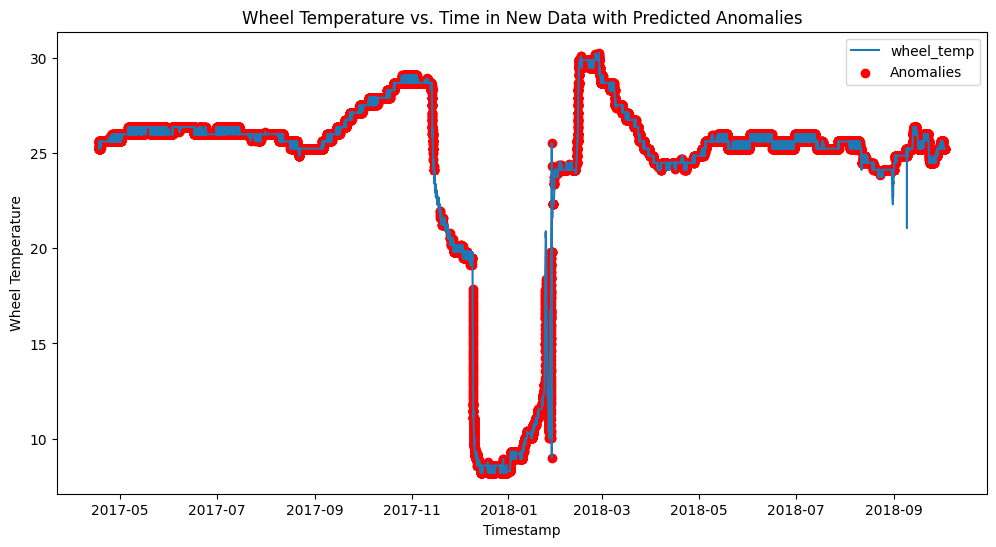

In [ ]:
# Visualize anomalies in new data
plt.figure(figsize=(12, 6))
plt.plot(new_data['Date_time'], new_data['wheel_temp'], label='wheel_temp')
plt.scatter(new_data[new_data['anomaly'] == 0]['Date_time'], new_data[new_data['anomaly'] == 0]['wheel_temp'], c='red', label='Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Wheel Temperature')
plt.title('Wheel Temperature vs. Time in New Data with Predicted Anomalies')
plt.legend()
plt.show()

In [ ]:
#Step# 8 Saving the model
#Save the model
joblib.dump(voting_classifier, r"D:\Uzair\Programming\KASBIT Space Hackathon\Models\model_wheel_temp.pkl")

['trained_model_wheel_temp.pkl']

In [ ]:
#Step 9: Making the api for web deployment of Model
#Making API for model deployment
from flask import Flask, request, jsonify
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

app = Flask(__name__)

# Load the trained model
model = joblib.load("trained_model_wheel_temp.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the POST request
        data = request.get_json(force=True)

        # Preprocess the data (you may need to adjust this based on your preprocessing steps)
        hour = data['hour']
        day_of_week = data['day_of_week']
        wheel_temp = data['wheel_temp']

        # Make predictions using the trained model
        prediction = model.predict([[hour, day_of_week, wheel_temp]])

        # Return the prediction as JSON response
        response = {'prediction': int(prediction[0])}
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
